In [1]:
def simulation_slimmed(t,x, dx, th, dth):
    assert x.shape == dx.shape
    assert th.shape == dth.shape
    n, ndim = x.shape
     
    u = np.r_[x.flatten(), dx.flatten(), th.flatten(), dth.flatten()]
         
    tspan = (t.min(), t.max())
    t_eval = t
    method = 'RK45'
    atol = rtol = 1e-8

    output = solve_ivp(
        lambda t, u: nbody_with_rotation(t, u, ndim, b,br,m,I,Rc,lc,beta),
        tspan, 
        u,
        t_eval=t_eval,
        method=method,
        atol=atol,
        rtol=rtol
    )
    
    pos = output["y"][:n*ndim].reshape((n, ndim, -1))
    vel = output["y"][ndim*n:2*ndim*n].reshape((n, ndim, -1))
    theta = output["y"][2*ndim*n:2*ndim*n+n].reshape((n, 1, -1))
    angular_velocity= output["y"][2*ndim*n+n:].reshape((n, 1, -1))
   
    return pos, vel, theta, angular_velocity

In [2]:
def savesim(results, resultsvel,  t, resultstheta, resultsangularvel,speeds,sizescatter,name, buffer = 0.5,save=1,colors =1):
        
        x = results[:,0,-1]
        y = results[:,1,-1]
        fig = plt.figure(figsize=(9,9))
        ax2 = plt.subplot(1,1,1)
        ax2.set_xlim((-Rc-buffer,Rc+buffer))
        ax2.set_ylim((-Rc-buffer,Rc+buffer))
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_title('Plotting Trajectories')
        scatters = ax2.scatter([], [])
        scatters.set_clim(vmin = 0,vmax = 2*np.pi)
        txt_title = ax2.set_title('')
        ax2.set_yticks([])
        ax2.set_xticks([])

        def drawframe(n):
            x = results[:,0,n]
            y = results[:,1,n]        
            resultstheta_fixed = resultstheta[:,0,n]%(2*np.pi)
            th1 = resultstheta_fixed; 
            data = np.stack([x, y]).T
            scatters.set_offsets(data)
            if colors == 1:
                scatters.set_array(th1)
            else:
                scatters.set_array(np.ones(np.size(th1)))
            scatters.set_sizes(sizescatter*np.ones(x.shape))
            txt_title.set_text('Frame = {0:4d}'.format(n))
            return scatters,
        anim = animation.FuncAnimation(fig, drawframe, frames=results.shape[2], interval = t[-1]/speeds, blit=True)
        if save == 0:
            return HTML(anim.to_html5_video())
        else:
            return anim.save(name) 

In [3]:
#In order to solve the various differential equations governing the motion of each constituent particle.
import numpy as np
from scipy.integrate import solve_ivp

#In order to generate figures to demonstrate the interactions as a function of time.
import matplotlib.pyplot as plt

#In order to visualize our plots as animations.
from IPython.display import HTML
from matplotlib import animation

### For each of our particles which move in two dimensions (x,y) and are free to rotate in one dimension, we will solve a coupled set of differential equations. For the $i^{th}$ particle, we solve:

$$ m\ddot{\mathbf{x}_i} + b_t\dot{\mathbf{x}} = \mathbf{F}_{\text{self-propulsion}} + \sum_{j \neq i} \mathbf{F}_{ij, \text{(pairwise interactions)}} + \mathbf{F}_{\text{confinement}}. $$

### Mathematically, we must compute the pairwise distances between the particles as this value will be used in computing the interaction forces and torques. To do this efficiently, we note that the pairwise distance between particles i and j can be represented as,

#### $$d_{ij} = |\mathbf{x_i} - \mathbf{x_j}|$$

### To compute this efficiently on software, we can "vectorize" the distance computation and generate matrices to work with. We begin by recasting the square distance as,

#### $$d_{ij}^2 = \left( \mathbf{x_i} - \mathbf{x_j}\right)^T\left( \mathbf{x_i} - \mathbf{x_j}\right)$$

### We can now construct a matrix $D_{ij}$ where the i,j component is given by $d_{ij}^2$.

In [4]:
def mermaid_force_torque(X, ths, Bo, M):
    
    """Computing net forces from pairwise interactions."""
    #Gram matrix.
    d2 = -2 * X @ X.T
    
    #Squared pairwise distances.
    diag = -0.5 * np.einsum('ii->i', d2)
    d2 += diag + diag[:, None]
    ths_matrix = ths - ths[:, None]
    
    #Preventing division by zero.
    np.einsum('ii->i', d2)[...] = 1
    r = d2[..., None]**(0.5) 
    
    #Adding net forces.
    F = np.nansum(((X [:,None,:] - X)/r)*(-M / r**4 + np.exp(-2*Bo**(1/2)*(r-1))), axis=0)

    #Phase difference matrix
    ths_matrix = ths - ths[:, None]

    #Adding net torques. #Since the particles are disks, there are no net torques. The code provided 
    #can be arbitrarily extended to different shapes.
    
    tau = 0*np.nansum(np.sin(-ths_matrix)/r, axis=0)

    return F,tau

In [5]:
def confining_force(X, Rc, lc, beta):
    
    rs = np.sum(np.abs(X)**2,axis=-1)**(1./2)
    
    F_v = beta/(2*lc) / ( np.cosh( (rs-Rc) / lc ))**2
    F_v_repped = np.array([F_v,]*2).transpose()
    
    newrs = np.array([rs,]*2).transpose()
     
    return -X/newrs*F_v_repped

In [6]:
def nbody_with_rotation(t, u, ndim, b,br,m,I,Rc,lc,beta):
    #Right-hand side function for the N-Body simulation.
    # --> Number of particles.
    n = len(u) // (2*ndim+2)
        
    # --> Initialize output vector.
    du = np.zeros_like(u)
        
    # --> Extract the positions and velocities.
    x, dx, th, dth = u[:ndim*n], u[ndim*n:2*ndim*n], u[2*ndim*n:2*ndim*n+n], u[2*ndim*n+n:]

    
    F,tau = mermaid_force_torque(x.reshape(n, ndim), th.reshape(n,1), Bo, M)
    # --> Compute the acceleration.
    ddx = (F - b*dx.reshape(n, ndim) + confining_force(x.reshape(n, ndim), Rc, lc, beta) )/m
    
    ddth = (tau - br*dth.reshape(n,1))/I
    
    # --> Return the time-derivatives for the ODE solver.
    du[:ndim*n] = dx
    du[ndim*n:2*ndim*n] = ddx.ravel()
    du[2*ndim*n:2*ndim*n+n] = dth
    du[2*ndim*n+n:] = ddth.ravel()
    return du

In [7]:
N = 250;
omega = 0+0.00*np.random.randn(N,1);
I = 0.1;
m = 0.1;
br = 1;
b = 0.5;
ndim = 2;
Bo = 1.5;
M = 1.5;
Rc = 20;
lc = 1;
beta = 10;

In [8]:
rs = (Rc-2*lc)*np.sqrt( np.random.random([N,1]))
ths = 2*np.pi*np.random.random([N,1])

xs = np.concatenate((rs*np.cos(ths),rs*np.sin(ths)),axis=1)
dxs = np.zeros((N,2));
th = 2*np.pi*np.random.random([N,1]);
dth = omega;
tend = 400;
t = np.linspace(0,tend,tend+1);

In [9]:
results,resultsvel, resultstheta, resultsangularvel = simulation_slimmed(t,xs, dxs, th, dth)

In [10]:
buffer = -lc;
speeds = 10;

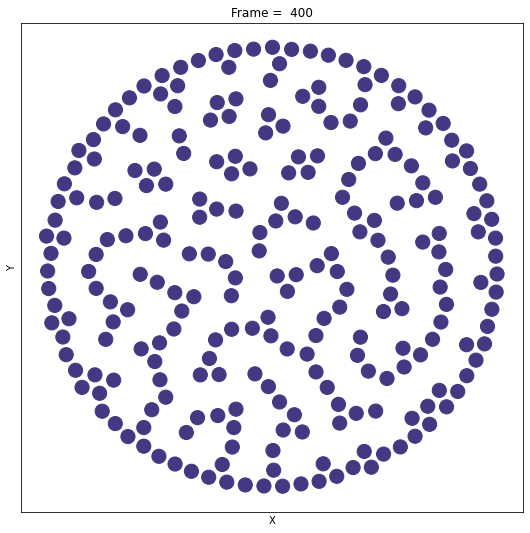

In [11]:
savesim(results, resultsvel,  t, resultstheta, resultsangularvel,speeds, 200,'confinedcereal.gif',buffer, 0,0)